In [1]:
println(VERSION, " (", Sys.CPU_NAME, ")")

1.7.0 (cyclone)


In [2]:
struct Config
  diagnostics
  solver
  pusher
  interactions
  species
  grid
end

In [3]:
# + units and constants
using Unitful
↦(value::Unitful.Units, unit::Unitful.Units) = Unitful.convfact(unit, value)
↦(value::Unitful.Quantity, unit::Unitful.Units) = uconvert(unit, value).val

# units
const °C = u"°C"
const K  = u"K"  ↦ u"K"
const kB = u"k"  ↦ u"J/K"
const C  = u"C"  ↦ u"C"
const V  = u"V"  ↦ u"V"
const m  = u"m"  ↦ u"m"
const cm = u"cm" ↦ u"m"
const u  = u"u"  ↦ u"kg"
const s  = u"s"  ↦ u"s"
const ms = u"ms" ↦ u"s"
const ns = u"ns" ↦ u"s"
const ps = u"ps" ↦ u"s"
const μs = u"μs" ↦ u"s"
const kV = u"MV" ↦ u"V"
const MV = u"MV" ↦ u"V"
const eV = u"eV" ↦ u"eV"
const kg = u"kg" ↦ u"kg"
const mps = u"m/s" ↦ u"m/s"
const kmps = u"km/s" ↦ u"m/s"
const kHz = u"kHz" ↦ u"Hz"
const MHz = u"MHz" ↦ u"Hz"

# constants
const ɛ0 = u"ɛ0" ↦ u"F/m"
const c0 = sqrt(u"1/ɛ0" * u"1/μ0") ↦ u"m/s"
const qe = 1.602_176_6208e-19C  # elementary charge
const me = 9.109_383_7015e-31kg # mass of electron
const mp = 1.672_621_8982e-27kg # mass of proton
nothing

In [4]:
function thermal_speed(T, m)
  sqrt(2kB*T/m)
end

thermal_speed (generic function with 1 method)

In [125]:
# + spatial and temporal paramters
const νtherm = thermal_speed(300K, me)
const νdrift = 1e7 #m/s
const mHe = 4.002602me/5.48579903e-04
const nHe = 1e24 # 1/m^3 number density
const ne = 1nHe
const f  = 9kHz # plasma frequency
const ω  = 2π * f * sqrt(2e-6ne)
const ds = 5e-3c0/ω
const ts = 1000
const nx = 32
const Δh = ds

const simulationVolume = nx * Δh
const numCells         = nx

const electronParticles    = 16 * numCells
const totalNumElectrons    = ne * simulationVolume
const electronNumRatio     = totalNumElectrons / electronParticles

Δt = .4Δh/νdrift/sqrt(2.0)
Lx = nx*Δh

println("Δt: ", Δt, "\nΔh: ", Δh, "\nLx: ", Lx)
println("νtherm: ", round(νtherm/c0; sigdigits=1), "c")
println("νdrift: ", round(νdrift/c0; sigdigits=3), "c")
println("electrons: ", electronParticles, " wg: ", electronNumRatio)

Δt: 5.30149462137438e-16
Δh: 1.8743613985989163e-8
Lx: 5.997956475516532e-7
νtherm: 0.0003c
νdrift: 0.0334c
electrons: 512 wg: 1.1714758741243228e15


In [126]:
using StaticArrays
include("ParticleInCell/src/pic/kinetic.jl");

In [127]:
# + species and sources
const e   = KineticSpecies{1,3}(:e,  20_000, -1qe, 1me,  electronNumRatio)
const iHe = KineticSpecies{1,3}(:iHe, 20_000, +1qe, 1mHe, electronNumRatio)

include("ParticleInCell/src/pic/sources.jl")
const fwd = MaxwellianSource{1,3}(electronParticles/2/Δt, [Lx,], [νtherm,νtherm,νtherm], dv=[+νdrift,0.,0.])
const rev = MaxwellianSource{1,3}(electronParticles/2/Δt, [Lx,], [νtherm,νtherm,νtherm], dv=[-νdrift,0.,0.])

const species = [e, iHe]

2-element Vector{KineticSpecies{1, 3}}:
 e
 iHe

In [128]:
using LinearAlgebra
using Statistics
using SparseArrays
include("pole/boundary_conditions.jl")
include("pole/gradient.jl")
include("pole/iterative_methods.jl")
include("pole/inplace_periodic_solver.jl")
include("pole/linear_solver.jl")
include("pole/linear_solver1.jl")

solution(ps::InPlacePeriodicSolver) = ps.u
gradient(ps::InPlacePeriodicSolver) = let periodic = PeriodicBC()
    GradientOperator(ps.nx, ps.δx, (periodic, periodic))
end

solution(ps::LinearSolver) = reshape(ps.u, ps.n...)
gradient(ps::LinearSolver) = GradientOperator(ps.n[1], ps.δ[1], ps.bcs)

function create_poisson_solver(grid, ε0)
    xf, = grid.coords
    ps = LinearSolver(xf; left=PeriodicBC(), right=PeriodicBC())
end

function calculate_electric_potential(ps, f)
    @inbounds for i in eachindex(f)
      f[i] /= ε0
    end
    solve!(ps, f)
    φ  = solution(ps)
end

calculate_electric_potential (generic function with 1 method)

In [232]:
using LinearAlgebra, StaticArrays
const xs = 0m:Δh:Lx
include("RegularGrids/src/uniform_grid.jl")
include("ParticleInCell/src/pic/pushers.jl")
const grid    = create_uniform_grid(xs)
const solver  = create_poisson_solver(grid, ε0)
const pusher  = create_boris_pusher(species)
nothing

In [283]:
include("ParticleInCell/src/pic/wrap.jl")
function after_push(part, grid)
  wrap!(part, grid, @SVector[1.0], 1)
end

function enter_loop() # uses global: e, iHe, fwd, rev
  e.np = 2
  e.x[1] = @SVector [Lx / 2.0]
  e.v[1] = @SVector[-0.1 * Δh / Δt, 0.0, 0.0]
  e.x[2] = @SVector [Lx / 4.0]
  e.v[2] = @SVector[-0.5 * Δh / Δt, 0.0, 0.0]
  iHe.np = 0
  #sample!(fwd, e, Δt)
  #sample!(rev, e, Δt)
  # place ions in the same positions as electrons
  #iHe.x .= e.x
  #iHe.v .= zero(e.v)
  #iHe.np = e.np
end

enter_loop (generic function with 1 method)

In [284]:
using Random; Random.seed!(0)

function after_loop(i, t, dt) 
end
function exit_loop() end

const diagnostics = Dict{String, Array{Float64, 2}}(
    "vxe-"  => zeros(nx, ts),
    "ne-"  => zeros(nx, ts),
    "nHe+" => zeros(nx, ts),
    "rho"  => zeros(nx, ts),
    "phi"  => zeros(nx, ts),
    "Ex"   => zeros(nx+1, ts),
    "Jx"   => zeros(nx+1, ts))

const config = Config(diagnostics, solver, pusher, [], species, grid)
println("[*] Running simulation")

struct FluidSpecies end
include("ParticleInCell/src/pic/algorithm.jl")
include("ParticleInCell/src/pic/cloud_in_cell.jl")
@time solve(config, Δt, 2)
@time solve(config, Δt, ts)

[*] Running simulation
i: 17 h1: 0.8999956029500105 h2: 1.1102230246251565e-15 di: 1.0
i: 9 h1: 0.49998680885002855 h2: 6.661338147750939e-16 di: 1.0
e 1.767766952966371e7
iHe 0.0
i: 17 h1: 0.7999841705040289 h2: 0.899995602950009 di: 0.0
i: 8 h1: 0.9999560291520799 h2: 0.49998680885002766 di: 1.0
e 1.7678757756320775e7
iHe 0.0
Complete!
  0.219693 seconds (736.26 k allocations: 41.113 MiB, 20.82% gc time, 98.92% compilation time)
i: 17 h1: 0.8999956029500105 h2: 1.1102230246251565e-15 di: 1.0
i: 9 h1: 0.49998680885002855 h2: 6.661338147750939e-16 di: 1.0
e 1.767766952966371e7
iHe 0.0
i: 17 h1: 0.7999841705040289 h2: 0.899995602950009 di: 0.0
i: 8 h1: 0.9999560291520799 h2: 0.49998680885002766 di: 1.0
e 1.7678757756320775e7
iHe 0.0
i: 17 h1: 0.6999630641304506 h2: 0.7999841705040288 di: 0.0
i: 8 h1: 0.4999032630441258 h2: 0.9999560291520792 di: 0.0
e 1.767611492542672e7
iHe 0.0
i: 17 h1: 0.5999296450424438 h2: 0.6999630641304492 di: 0.0
i: 7 h1: 0.999832906184067 h2: 0.4999032630441264

i: 9 h1: 0.5019377302412558 h2: 0.001719776927000094 di: 1.0
e 1.7669963716339078e7
iHe 0.0
i: 11 h1: 0.36270500040661524 h2: 0.4634919319808363 di: 0.0
i: 9 h1: 0.002129369417943394 h2: 0.501937730241258 di: 0.0
e 1.760238495190974e7
iHe 0.0
i: 11 h1: 0.26195720978848946 h2: 0.362705000406617 di: 0.0
i: 8 h1: 0.502299079522337 h2: 0.002129369417942284 di: 1.0
e 1.7671669371381022e7
iHe 0.0
i: 11 h1: 0.16125381028186148 h2: 0.26195720978848847 di: 0.0
i: 8 h1: 0.0024424679817931505 h2: 0.5022990795223372 di: 0.0
e 1.759131524602584e7
iHe 0.0
i: 11 h1: 0.06059125950368127 h2: 0.16125381028186261 di: 0.0
i: 7 h1: 0.5025595600585353 h2: 0.0024424679817929285 di: 1.0
e 1.76735296995893e7
iHe 0.0
i: 10 h1: 0.959966016507801 h2: 0.060591259503680384 di: 1.0
i: 7 h1: 0.0026415657714604635 h2: 0.5025595600585355 di: 0.0
e 1.758427607616619e7
iHe 0.0
i: 10 h1: 0.8593833357604161 h2: 0.9599660165078024 di: 0.0
i: 6 h1: 0.502701655925013 h2: 0.0026415657714611296 di: 1.0
e 1.7675545021910734e7
iH

i: 4 h1: 0.6372242826673093 h2: 0.7378854269841384 di: 0.0
i: 7 h1: 0.4986023934235426 h2: 0.9985060984427658 di: 0.0
e 1.7624852133586418e7
iHe 0.0
i: 4 h1: 0.536540376342721 h2: 0.6372242826673093 di: 0.0
i: 6 h1: 0.998725033832188 h2: 0.49860239342354284 di: 1.0
e 1.7673333536433663e7
iHe 0.0
i: 4 h1: 0.4358310517373569 h2: 0.5365403763427208 di: 0.0
i: 6 h1: 0.49886962585424666 h2: 0.9987250338321878 di: 0.0
e 1.7632592668511517e7
iHe 0.0
i: 4 h1: 0.33509252329131556 h2: 0.43583105173735726 di: 0.0
i: 5 h1: 0.9990405703543805 h2: 0.4988696258542471 di: 1.0
e 1.7671625728901144e7
iHe 0.0
i: 4 h1: 0.23432915558112155 h2: 0.33509252329131534 di: 0.0
i: 5 h1: 0.499233474792506 h2: 0.9990405703543799 di: 0.0
e 1.7643748569239218e7
iHe 0.0
i: 4 h1: 0.13353651799112498 h2: 0.2343291555811214 di: 0.0
i: 4 h1: 0.9994527278260801 h2: 0.49923347479250624 di: 1.0
e 2.1233475641000133e7
iHe 0.0
i: 4 h1: 0.03272132138562611 h2: 0.1335365179911248 di: 0.0
i: 4 h1: 0.4996939420457762 h2: 0.9994527

i: 29 h1: 0.9080104366404456 h2: 0.00776378903553443 di: 1.0
i: 6 h1: 0.0012274260960563055 h2: 0.5012548650617495 di: 0.0
e 1.763427346386735e7
iHe 0.0
i: 29 h1: 0.8082590543990982 h2: 0.9080104366404487 di: 0.0
i: 5 h1: 0.5012131890744431 h2: 0.0012274260960565275 di: 1.0
e 1.7678172884390026e7
iHe 0.0
i: 29 h1: 0.7085070106405986 h2: 0.8082590543990968 di: 0.0
i: 5 h1: 0.0012165509216988113 h2: 0.5012131890744433 di: 0.0
e 1.763465795934409e7
iHe 0.0
i: 29 h1: 0.6087535073081121 h2: 0.7085070106405981 di: 0.0
i: 4 h1: 0.5012375223658583 h2: 0.0012165509216990333 di: 1.0
e 1.7676928077144876e7
iHe 0.0
i: 29 h1: 0.5090047859217108 h2: 0.6087535073081138 di: 0.0
i: 4 h1: 0.0012761146586668382 h2: 0.5012375223658585 di: 0.0
e 1.7632552063227944e7
iHe 0.0
i: 29 h1: 0.4092476663802671 h2: 0.509004785921713 di: 0.0
i: 3 h1: 0.5013279542128464 h2: 0.001276114658666394 di: 1.0
e 1.767583672464897e7
iHe 0.0
i: 29 h1: 0.30949614859842356 h2: 0.40924766638026966 di: 0.0
i: 3 h1: 0.0013886462578

i: 23 h1: 0.2399521783790206 h2: 0.3391425693082183 di: 0.0
i: 4 h1: 0.5082948859833261 h2: 0.008462527233185302 di: 1.0
e 1.768359654289279e7
iHe 0.0
i: 23 h1: 0.1407503530171077 h2: 0.23995217837902183 di: 0.0
i: 4 h1: 0.008136257671618186 h2: 0.508294885983326 di: 0.0
e 1.7390009381009575e7
iHe 0.0
i: 23 h1: 0.041532731268624445 h2: 0.1407503530171078 di: 0.0
i: 3 h1: 0.5079735900652373 h2: 0.00813625767161863 di: 1.0
e 1.7683420698041268e7
iHe 0.0
i: 22 h1: 0.9422949504851417 h2: 0.041532731268622225 di: 1.0
i: 3 h1: 0.007802478961616011 h2: 0.5079735900652375 di: 0.0
e 1.7401810240472488e7
iHe 0.0
i: 22 h1: 0.8430375516458 h2: 0.9422949504851428 di: 0.0
i: 2 h1: 0.507622710989573 h2: 0.007802478961615789 di: 1.0
e 1.7684025287267268e7
iHe 0.0
i: 22 h1: 0.7437658373326208 h2: 0.8430375516458016 di: 0.0
i: 2 h1: 0.007442943017530457 h2: 0.5076227109895732 di: 0.0
e 1.741452175567965e7
iHe 0.0
i: 22 h1: 0.6444763155240771 h2: 0.7437658373326199 di: 0.0
i: 33 h1: 0.507258712541514 h2:

i: 3 h1: 0.014559832396838335 h2: 0.5147452824130552 di: 0.0
e 1.716290171862649e7
iHe 0.0
i: 16 h1: 0.44328723325038233 h2: 0.5437616831862561 di: 0.0
i: 2 h1: 0.5143701133712528 h2: 0.014559832396838779 di: 1.0
e 1.7684377110139284e7
iHe 0.0
i: 16 h1: 0.3427941976390638 h2: 0.44328723325038244 di: 0.0
i: 2 h1: 0.014171726617899116 h2: 0.5143701133712526 di: 0.0
e 1.717662333003177e7
iHe 0.0
i: 16 h1: 0.24227942637715216 h2: 0.3427941976390645 di: 0.0
i: 33 h1: 0.513973339864549 h2: 0.014171726617902447 di: 1.0
e 1.768468356059338e7
iHe 0.0
i: 16 h1: 0.14175359459476589 h2: 0.24227942637715133 di: 0.0
i: 33 h1: 0.013783624328226551 h2: 0.5139733398645464 di: 0.0
e 1.7190344818072844e7
iHe 0.0
i: 16 h1: 0.04121831144825627 h2: 0.14175359459476305 di: 0.0
i: 32 h1: 0.5135984270564649 h2: 0.013783624328223443 di: 1.0
e 1.7684217241999578e7
iHe 0.0
i: 15 h1: 0.940662130485654 h2: 0.04121831144825849 di: 1.0
i: 32 h1: 0.013431176742447093 h2: 0.5135984270564616 di: 0.0
e 1.720280572196872e

e 1.768201865035971e7
iHe 0.0
i: 9 h1: 0.6851513113572203 h2: 0.7856628367893679 di: 0.0
i: 33 h1: 0.019321501579511846 h2: 0.5194445132889661 di: 0.0
e 1.6994551290184718e7
iHe 0.0
i: 9 h1: 0.5846446706425041 h2: 0.6851513113572204 di: 0.0
i: 32 h1: 0.5191939229048472 h2: 0.019321501579508737 di: 1.0
e 1.768218011696309e7
iHe 0.0
i: 9 h1: 0.4841498015225554 h2: 0.5846446706425041 di: 0.0
i: 32 h1: 0.019084101223427297 h2: 0.5191939229048489 di: 0.0
e 1.700294466026689e7
iHe 0.0
i: 9 h1: 0.3836721024378793 h2: 0.48414980152255566 di: 0.0
i: 31 h1: 0.5189922033969587 h2: 0.019084101223429073 di: 1.0
e 1.7680918608477365e7
iHe 0.0
i: 9 h1: 0.28320892255568 h2: 0.3836721024378789 di: 0.0
i: 31 h1: 0.01892685488976653 h2: 0.5189922033969572 di: 0.0
e 1.7008504157709304e7
iHe 0.0
i: 9 h1: 0.18275761142621327 h2: 0.28320892255567975 di: 0.0
i: 30 h1: 0.518888221571828 h2: 0.018926854889765865 di: 1.0
e 1.767903542371837e7
iHe 0.0
i: 9 h1: 0.08230951467416148 h2: 0.18275761142621344 di: 0.0
i

i: 31 h1: 0.5197411401858005 h2: 0.019609556535998607 di: 1.0
e 1.767301734511028e7
iHe 0.0
i: 2 h1: 0.8393448942197952 h2: 0.9403424661422737 di: 0.0
i: 31 h1: 0.019881865146704314 h2: 0.5197411401858001 di: 0.0
e 1.6974739446270134e7
iHe 0.0
i: 2 h1: 0.7383589420314238 h2: 0.8393448942197954 di: 0.0
i: 30 h1: 0.5200363057869097 h2: 0.019881865146703648 di: 1.0
e 1.7672209228464663e7
iHe 0.0
i: 2 h1: 0.6373863857382798 h2: 0.7383589420314238 di: 0.0
i: 30 h1: 0.02020006913092587 h2: 0.5200363057869093 di: 0.0
e 1.6963489236517955e7
iHe 0.0
i: 2 h1: 0.5364214153555047 h2: 0.6373863857382797 di: 0.0
i: 29 h1: 0.5203775565491959 h2: 0.020200069130924536 di: 1.0
e 1.767139440181194e7
iHe 0.0
i: 2 h1: 0.4354818663919695 h2: 0.5364214153555045 di: 0.0
i: 29 h1: 0.02054714587883666 h2: 0.5203775565491983 di: 0.0
e 1.6951218220415957e7
iHe 0.0
i: 2 h1: 0.3345587708705624 h2: 0.43548186639196973 di: 0.0
i: 28 h1: 0.5207128802394507 h2: 0.020547145878837547 di: 1.0
e 1.767180993515043e7
iHe 0.0

i: 30 h1: 0.019440541712761217 h2: 0.5191096522239613 di: 0.0
e 1.699034258591202e7
iHe 0.0
i: 28 h1: 0.11785821257603857 h2: 0.2178439711456703 di: 0.0
i: 29 h1: 0.5198203116376625 h2: 0.019440541712762327 di: 1.0
e 1.7664242635204308e7
iHe 0.0
i: 28 h1: 0.01785357812716626 h2: 0.11785821257603644 di: 0.0
i: 29 h1: 0.020236129471498998 h2: 0.5198203116376622 di: 0.0
e 1.6962214310950395e7
iHe 0.0
i: 27 h1: 0.917827743459096 h2: 0.01785357812716426 di: 1.0
i: 28 h1: 0.5206748223480204 h2: 0.020236129471500997 di: 1.0
e 1.7662159394271433e7
iHe 0.0
i: 27 h1: 0.8177924533237615 h2: 0.9178277434590986 di: 0.0
i: 28 h1: 0.02114062479030565 h2: 0.5206748223480226 di: 0.0
e 2.046701717290944e7
iHe 0.0
i: 27 h1: 0.717765137280086 h2: 0.8177924533237572 di: 0.0
i: 27 h1: 0.5216251309091575 h2: 0.02114062479030321 di: 1.0
e 1.7660539651555277e7
iHe 0.0
i: 27 h1: 0.6177424324751613 h2: 0.717765137280086 di: 0.0
i: 27 h1: 0.02210217414297233 h2: 0.5216251309091562 di: 0.0
e 1.6896239668890603e7
i

iHe 0.0
i: 21 h1: 0.4476983824128311 h2: 0.5474875836961481 di: 0.0
i: 28 h1: 0.019217657986903447 h2: 0.5190443381545136 di: 0.0
e 1.6998222715610527e7
iHe 0.0
i: 21 h1: 0.3478730848382803 h2: 0.4476983824128315 di: 0.0
i: 27 h1: 0.5194180361272593 h2: 0.019217657986902337 di: 1.0
e 1.767058509257129e7
iHe 0.0
i: 21 h1: 0.24800993522519832 h2: 0.3478730848382787 di: 0.0
i: 27 h1: 0.019636685524183406 h2: 0.5194180361272589 di: 0.0
e 1.6983407854954798e7
iHe 0.0
i: 21 h1: 0.1481137552347036 h2: 0.24800993522520012 di: 0.0
i: 26 h1: 0.5198820625950056 h2: 0.019636685524185182 di: 1.0
e 1.766899414012745e7
iHe 0.0
i: 21 h1: 0.048187608952968475 h2: 0.148113755234702 di: 0.0
i: 26 h1: 0.020154346500305564 h2: 0.519882062595002 di: 0.0
e 1.696510577562622e7
iHe 0.0
i: 20 h1: 0.9482191872379353 h2: 0.048187608952971805 di: 1.0
i: 25 h1: 0.5204579414735591 h2: 0.02015434650030601 di: 1.0
e 1.766693582644762e7
iHe 0.0
i: 20 h1: 0.8482225617603731 h2: 0.9482191872379321 di: 0.0
i: 25 h1: 0.020

i: 14 h1: 0.7155549364612899 h2: 0.8166013988375541 di: 0.0
i: 26 h1: 0.5243323056857676 h2: 0.02429035384410927 di: 1.0
e 1.7676186308077697e7
iHe 0.0
i: 14 h1: 0.6144858830084061 h2: 0.7155549364612892 di: 0.0
i: 26 h1: 0.024392487669576468 h2: 0.5243323056857685 di: 0.0
e 1.681526485760535e7
iHe 0.0
i: 14 h1: 0.5133924608561831 h2: 0.6144858830084071 di: 0.0
i: 25 h1: 0.524466504333283 h2: 0.024392487669576912 di: 1.0
e 1.767505264542232e7
iHe 0.0
i: 14 h1: 0.41229024460397845 h2: 0.5133924608561838 di: 0.0
i: 25 h1: 0.024558754679606665 h2: 0.5244665043332818 di: 0.0
e 1.6809386431091353e7
iHe 0.0
i: 14 h1: 0.3111688974950919 h2: 0.41229024460397673 di: 0.0
i: 24 h1: 0.5246648440923352 h2: 0.024558754679606 di: 1.0
e 1.7673918702506047e7
iHe 0.0
i: 14 h1: 0.2100266409870546 h2: 0.3111688974950923 di: 0.0
i: 24 h1: 0.024797749615217413 h2: 0.524664844092334 di: 0.0
e 1.680093668410937e7
iHe 0.0
i: 14 h1: 0.10886169616963137 h2: 0.2100266409870541 di: 0.0
i: 23 h1: 0.5249449366575227

i: 25 h1: 0.027546174088410424 h2: 0.5275432044214037 di: 0.0
e 1.670376520498068e7
iHe 0.0
i: 7 h1: 0.8430050563229452 h2: 0.9436903035627986 di: 0.0
i: 24 h1: 0.5275542675368321 h2: 0.027546174088407538 di: 1.0
e 1.767738338305048e7
iHe 0.0
i: 7 h1: 0.7423200642453889 h2: 0.8430050563229453 di: 0.0
i: 24 h1: 0.027571882030187567 h2: 0.5275542675368308 di: 0.0
e 1.6702856291982632e7
iHe 0.0
i: 7 h1: 0.6416326710284679 h2: 0.7423200642453883 di: 0.0
i: 23 h1: 0.5275775177230102 h2: 0.027571882030189343 di: 1.0
e 1.7677470277833175e7
iHe 0.0
i: 7 h1: 0.5409402203071751 h2: 0.641632671028468 di: 0.0
i: 23 h1: 0.02756653529365849 h2: 0.527577517723008 di: 0.0
e 1.6703045327665478e7
iHe 0.0
i: 7 h1: 0.4402488496830541 h2: 0.540940220307175 di: 0.0
i: 22 h1: 0.5275342948829582 h2: 0.02756653529365871 di: 1.0
e 1.767880940031542e7
iHe 0.0
i: 7 h1: 0.33955590268616387 h2: 0.4402488496830545 di: 0.0
i: 22 h1: 0.027494228929644038 h2: 0.5275342948829576 di: 0.0
e 1.6705601743681356e7
iHe 0.0
i:

i: 33 h1: 0.07657619672602323 h2: 0.17750560926336606 di: 0.0
i: 23 h1: 0.029846910180115316 h2: 0.5297045621805031 di: 0.0
e 1.6622421900372423e7
iHe 0.0
i: 32 h1: 0.9756569251261276 h2: 0.07657619672602856 di: 1.0
i: 22 h1: 0.5299815139865949 h2: 0.029846910180114872 di: 1.0
e 1.767291056644691e7
iHe 0.0
i: 32 h1: 0.8747631795244324 h2: 0.9756569251261263 di: 0.0
i: 22 h1: 0.03009984789526854 h2: 0.5299815139865933 di: 0.0
e 1.6613479201692289e7
iHe 0.0
i: 32 h1: 0.7738991119275482 h2: 0.874763179524428 di: 0.0
i: 21 h1: 0.5301928583082862 h2: 0.030099847895268095 di: 1.0
e 1.7674381114975385e7
iHe 0.0
i: 32 h1: 0.6730638353267864 h2: 0.7738991119275467 di: 0.0
i: 21 h1: 0.03025148887842377 h2: 0.5301928583082872 di: 0.0
e 1.6608117883317545e7
iHe 0.0
i: 32 h1: 0.5722522346886763 h2: 0.6730638353267897 di: 0.0
i: 20 h1: 0.5302801382024818 h2: 0.03025148887842688 di: 1.0
e 1.7676656623097908e7
iHe 0.0
i: 32 h1: 0.4714770812372393 h2: 0.5722522346886756 di: 0.0
i: 20 h1: 0.030291731899

i: 21 h1: 0.5328254783679256 h2: 0.03260819867292364 di: 1.0
e 1.766998753237619e7
iHe 0.0
i: 26 h1: 0.2570717286146724 h2: 0.3570241259019725 di: 0.0
i: 21 h1: 0.03300873634515611 h2: 0.5328254783679247 di: 0.0
e 1.6510634464260753e7
iHe 0.0
i: 26 h1: 0.15714809872077495 h2: 0.2570717286146701 di: 0.0
i: 20 h1: 0.5331579790509728 h2: 0.03300873634515633 di: 1.0
e 1.7672393003197417e7
iHe 0.0
i: 26 h1: 0.05725060000510851 h2: 0.15714809872077395 di: 0.0
i: 20 h1: 0.033264417635212595 h2: 0.5331579790509715 di: 0.0
e 1.6501594765559679e7
iHe 0.0
i: 25 h1: 0.9573727033594075 h2: 0.05725060000510829 di: 1.0
i: 19 h1: 0.5333456440419653 h2: 0.033264417635210375 di: 1.0
e 1.76747977425123e7
iHe 0.0
i: 25 h1: 0.8575244614575155 h2: 0.9573727033594073 di: 0.0
i: 19 h1: 0.033383779683596515 h2: 0.5333456440419657 di: 0.0
e 1.649737467986825e7
iHe 0.0
i: 25 h1: 0.7577000959673086 h2: 0.8575244614575178 di: 0.0
i: 18 h1: 0.5333920167161814 h2: 0.03338377968359674 di: 1.0
e 1.7677378306583814e7
i

iHe 0.0
i: 19 h1: 0.5684754860678716 h2: 0.6690644356038542 di: 0.0
i: 19 h1: 0.528576549416595 h2: 0.02823640144537709 di: 1.0
e 1.7665643482810937e7
iHe 0.0
i: 19 h1: 0.46787256141355016 h2: 0.5684754860678711 di: 0.0
i: 19 h1: 0.028900617018049246 h2: 0.528576549416598 di: 0.0
e 1.7791754900298443e7
iHe 0.0
i: 19 h1: 0.3672676590358819 h2: 0.4678725614135524 di: 0.0
i: 18 h1: 0.5291956843539722 h2: 0.028900617018047026 di: 1.0
e 1.766723732395672e7
iHe 0.0
i: 19 h1: 0.2666633799278486 h2: 0.3672676590358781 di: 0.0
i: 18 h1: 0.02943978433838268 h2: 0.5291956843539753 di: 0.0
e 1.6636815972546693e7
iHe 0.0
i: 19 h1: 0.1660596869775368 h2: 0.2666633799278499 di: 0.0
i: 17 h1: 0.5296368112549246 h2: 0.02943978433838046 di: 1.0
e 1.767070357622546e7
iHe 0.0
i: 19 h1: 0.06545597801370562 h2: 0.16605968697753887 di: 0.0
i: 17 h1: 0.02978211608790815 h2: 0.5296368112549275 di: 0.0
e 1.6624712717471449e7
iHe 0.0
i: 18 h1: 0.9648545715555308 h2: 0.06545597801370384 di: 1.0
i: 16 h1: 0.529879

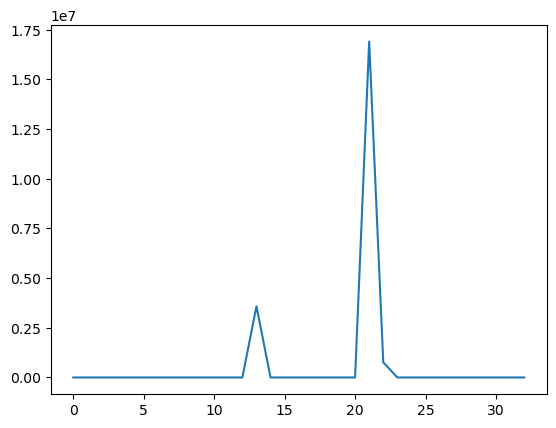

i: 13 h1: 0.6156526983116386 h2: 0.7170187317538796 di: 0.0
i: 22 h1: 0.021623304620213446 h2: 0.5215733086037484 di: 0.0


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x178bd4250>

In [285]:
import PyPlot

include("ParticleInCell/src/pic/algorithm.jl")

cur = zeros(nx+1)
current_deposition(cur, e, Δh, Δt)
PyPlot.plot(cur)

In [286]:
e.v

20000-element Vector{SVector{3, Float64}}:
 [-3.583830481449552e6, 0.0, 0.0]
 [-1.7675901903549954e7, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 ⋮
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]

In [287]:
include("ParticleInCell/src/pic/pushers.jl")
include("ParticleInCell/src/pic/wrap.jl")

wrap! (generic function with 1 method)

In [288]:
import Pkg
Pkg.activate(".")
Pkg.add("PyPlot")
Pkg.resolve()

  Activating project at `~/iskra`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`


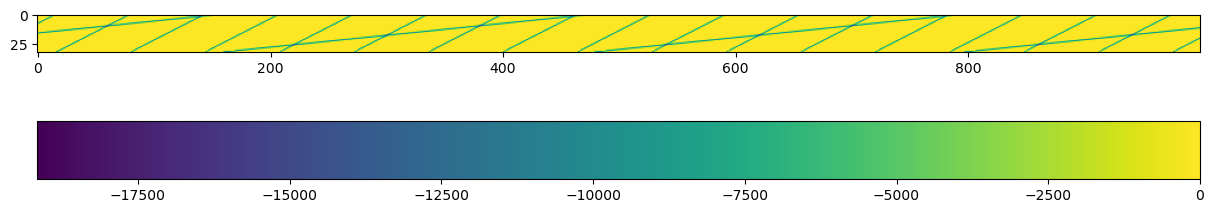

In [289]:
import PyPlot
PyPlot.figure(figsize=(15, 6))
PyPlot.imshow(diagnostics["rho"])
PyPlot.colorbar(orientation="horizontal");

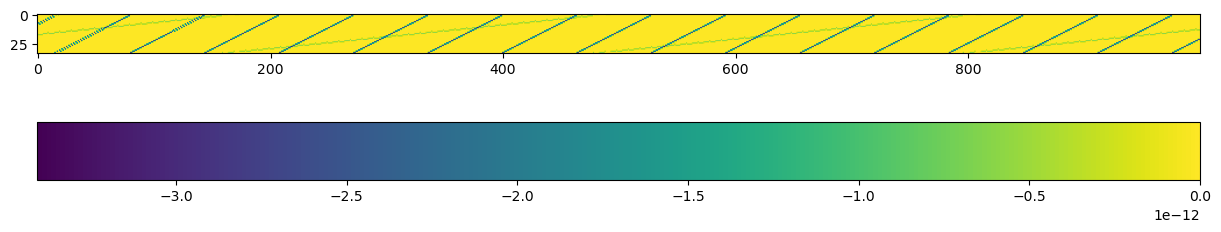

In [290]:
import PyPlot
PyPlot.figure(figsize=(15, 6))
PyPlot.imshow(diagnostics["Jx"])
PyPlot.colorbar(orientation="horizontal");

In [291]:
it = 400
Jx = diagnostics["Jx"][:,it]
ρ1 = diagnostics["rho"][:,it]
ρ2 = diagnostics["rho"][:,it+1]
nothing

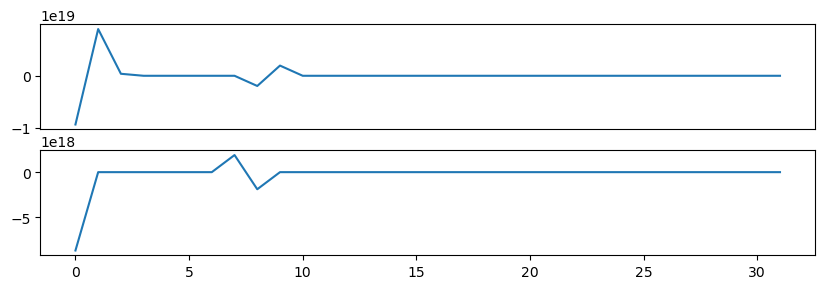

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x17a8f9c10>

In [292]:
PyPlot.figure(figsize=(10,3))
PyPlot.subplot(2,1,1)
PyPlot.plot(5.5e7electronNumRatio*diff(Jx)/Δh)
PyPlot.xticks([])
PyPlot.subplot(2,1,2)
PyPlot.plot((ρ1 - ρ2)/Δt)

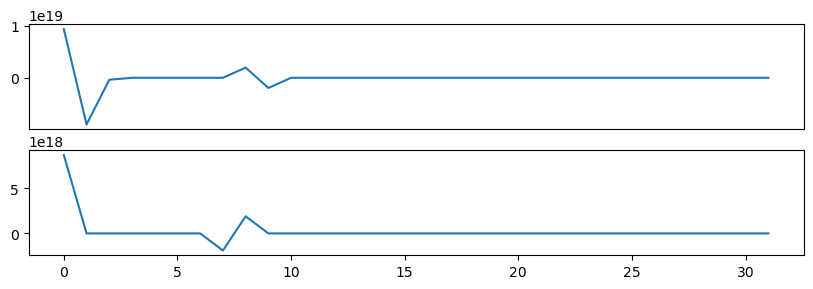

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x16ba6db80>

In [293]:
PyPlot.figure(figsize=(10,3))
PyPlot.subplot(2,1,1)
PyPlot.plot([5.5e7electronNumRatio * (Jx[i] - Jx[i+1]) / Δh for i in 1:nx])
PyPlot.xticks([])
PyPlot.subplot(2,1,2)
PyPlot.plot([(ρ2[i] - ρ1[i]) / Δt for i in 1:nx])

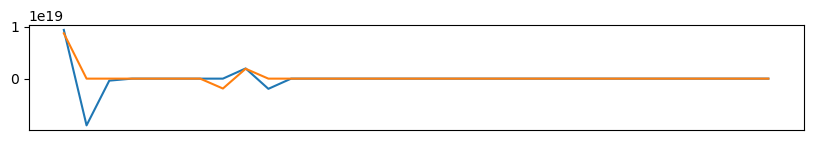

(Any[], Any[])

In [294]:
PyPlot.figure(figsize=(10,3))
PyPlot.subplot(2,1,1)
PyPlot.plot([5.5e7electronNumRatio * (Jx[i] - Jx[i+1]) / Δh for i in 1:nx])
PyPlot.plot([(ρ2[i] - ρ1[i]) / Δt for i in 1:nx])
PyPlot.xticks([])